# QR Decomposition

In [ ]:
import numpy as np

In [ ]:
from sympy import Matrix, init_printing
init_printing()

In [ ]:
import logging
logging.basicConfig(
    format='%(asctime)s-%(levelname)s: %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    #level=logging.INFO,
    level=logging.DEBUG,
)

## 1. QR decomposition. Thin QR

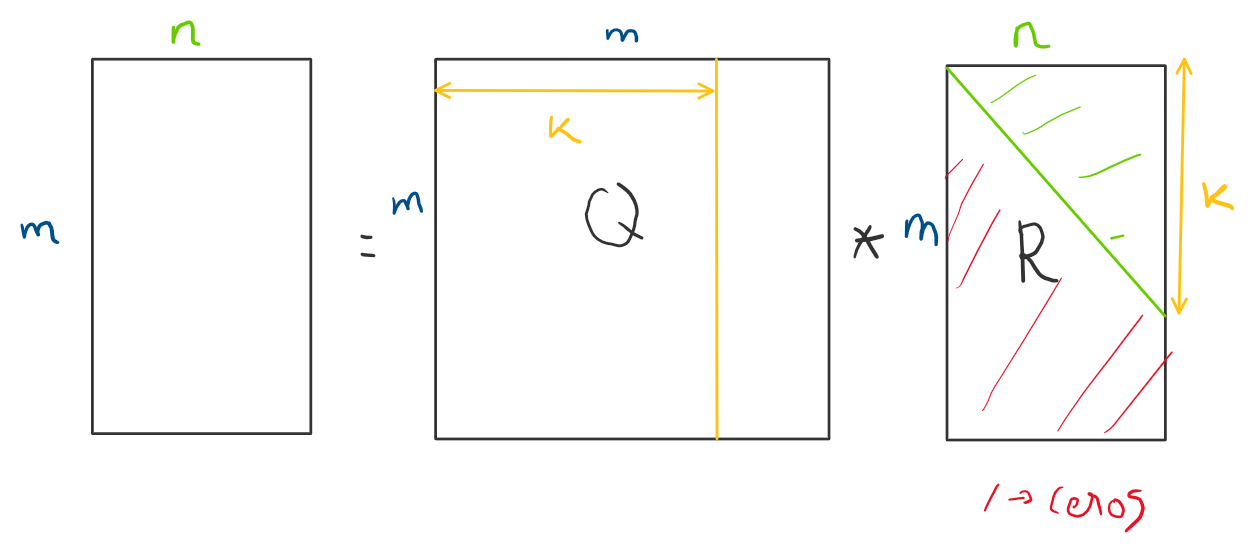

In this case the number of elements of the decomposition in matrix Q and R can be lower than the number of elements of the original matrix. Only if $m > n$

## 2. No thin QR decomposition

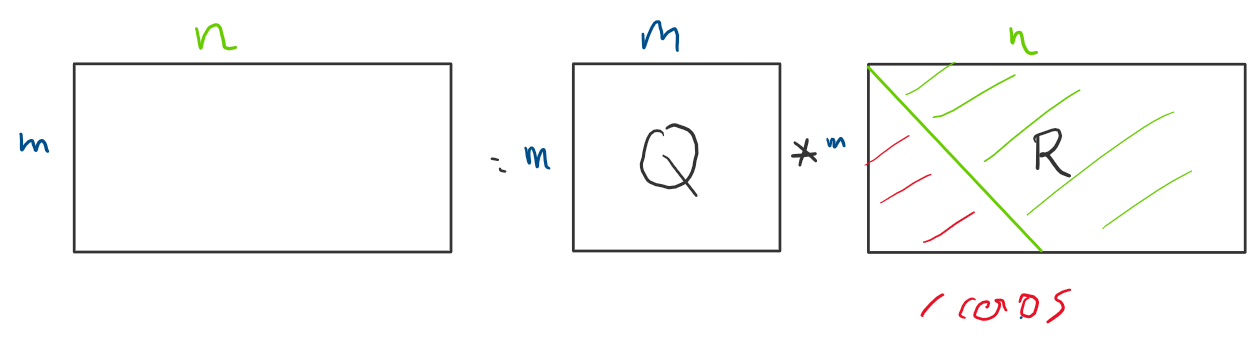

When $m<n$ thin decomposition can not be done. In this case number of elements of Q and R will be higher than the number of elements of the original matrix

## 3. QR decompostion of rank-n Tensor

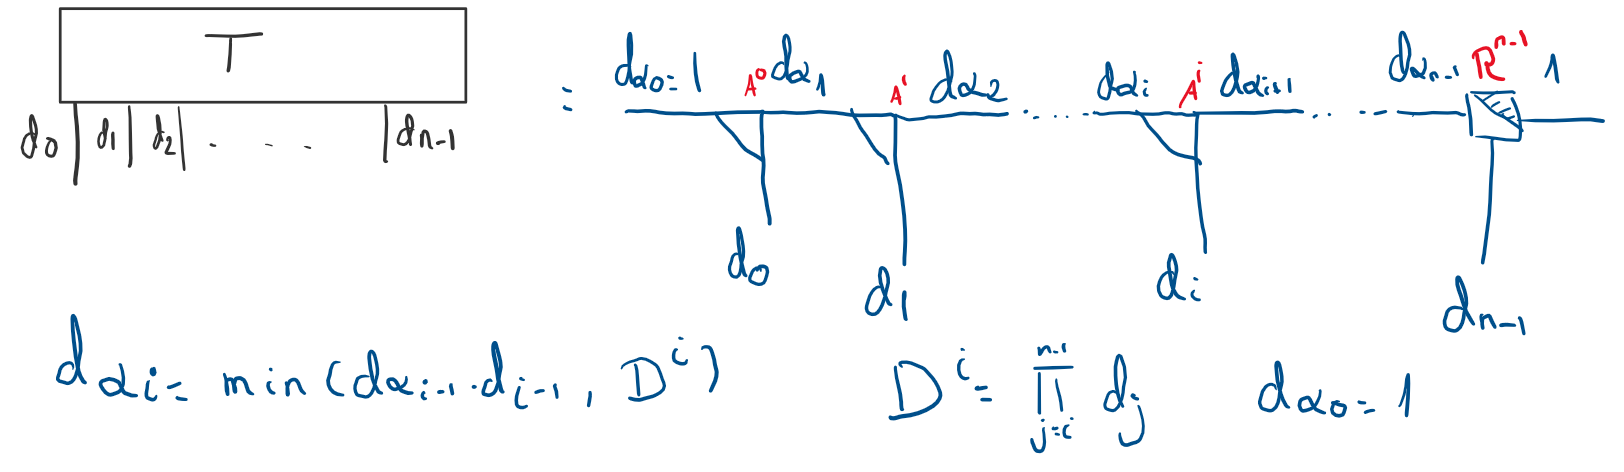

Where the 3-rank tensors are:

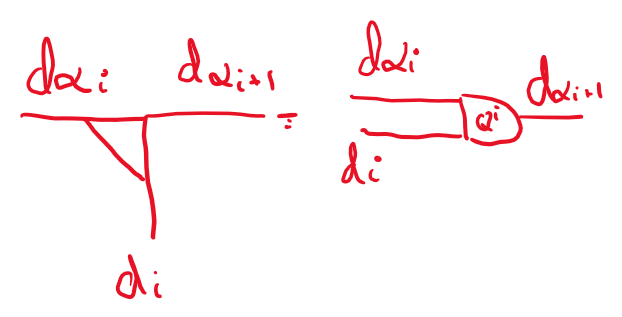

Where the first tensor is the indentity tensor and the second one is the isometric matrix from $Q^i$ from the $i$ QR decomposition

## 4. Manual QR Decomposition

In [ ]:
tensor_dim = [2, 3, 2, 3, 4] # local space dimensions
T = np.random.random(tuple(tensor_dim)) # rank-5 tensor
T = T / np.linalg.norm(T)

In [ ]:
M_T = T.reshape(tensor_dim[0], np.prod(tensor_dim[1:]))
M_T.shape

### First Leg decompostion

In this case the *M_T* matrix of the tensor *T* has shape $(m,n)$ with $m<n$ so no thin QR.

In [ ]:
q0, r0 = np.linalg.qr(M_T, 'reduced')
s0 = q0.size + r0.size
print('q0: {}. r0: {} Mt: {}'.format(q0.shape, r0.shape, M_T.shape))
q0.shape
# Reshape to rank 3 tensor
q0 = q0.reshape([1, tensor_dim[0], -1])
q0.shape

As can be seen *q0* is a square matrix and *r0* has the same dimensions that the input matrix. So full-QR was done

### Second Leg decomposition

Now the *r0* is reshaped to (d0*d1, d2*d3*d4) matrix and QR proccess is done again. Again *d0d1* < *d2d3d4* so ful QR is done again

In [ ]:
r0 = r0.reshape(r0.shape[0]*tensor_dim[1], np.prod(tensor_dim[2:]))
q1, r1 = np.linalg.qr(r0, 'reduced')
print('q1: {}. r1: {} r0: {}'.format(q1.shape, r1.shape, r0.shape))
s1 = q1.size + r1.size
print(r1.shape)
q1 = q1.reshape([q0.shape[-1], tensor_dim[1], -1])
q1.shape

Again the resultant QR decomposition is full: q1 is square matrix and r1 is of the same shape that the input matrix r0

### Third Leg

Here the input matrix is a square one. Again only full QR is allowed.


In [ ]:
r1 = r1.reshape(r1.shape[0]*tensor_dim[2], np.prod(tensor_dim[3:]))
q2, r2 = np.linalg.qr(r1, 'reduced')
print('q2: {}. r2: {} r1: {}'.format(q2.shape, r2.shape, r1.shape))
s2 = q2.size + r2.size
q2 = q2.reshape([q1.shape[-1], tensor_dim[2], -1])
q2.shape

## Fourth leg

In this case the input matrix, r2, has $m>n$ dimensions so QR can be thin.

In [ ]:
r2 = r2.reshape(r2.shape[0]*tensor_dim[3], np.prod(tensor_dim[4:]))
q3, r3 = np.linalg.qr(r2, 'reduced')
print('q3: {}. r3: {} r2: {}'.format(q3.shape, r3.shape, r2.shape))
s3 = q3.size + r3.size
q3 = q3.reshape([q2.shape[-1], tensor_dim[3], -1])
q3.shape

As can be seen q3 is not a square matrix so is not an unitary matrix but it is an isometric one!!

### Last Leg

The last r3 matrix should be converted to a rank-3 tensor to finish the procces.

In [ ]:
r3 = r3.reshape(q3.shape[-1], tensor_dim[4], -1)
r3.shape

### Testing Decomposition

In [ ]:
import sys
sys.path.append('../tensornetworks/')
import tensornetworks as tn

In [ ]:
q0q1 = tn.contract_indices(q0, q1, [2], [0])
q0q1q2 = tn.contract_indices(q0q1, q2, [q0q1.ndim-1], [0])
q0q1q2q3 = tn.contract_indices(q0q1q2, q3, [q0q1q2.ndim-1], [0])
q5 = tn.contract_indices(q0q1q2q3, r3, [q0q1q2q3.ndim-1], [0])

In [ ]:
np.isclose(q5.reshape(T.shape), T).all()

In [ ]:
# Numero de elementos de la descomposicion QR del tensor T
q0.size + q1.size + q2.size + q3.size + r3.size

In [ ]:
#Numero de elementos originales
T.size

In [ ]:
# s0, s1, s2, s3 numero de elementos totales de las 4 descomposiciones QR
print('Matriz M : {} QR: {}'.format(M_T.size, s0))
print('Matriz r0 : {} QR: {}'.format(r0.size, s1))
print('Matriz r1 : {} QR: {}'.format(r1.size, s2))
print('Matriz r2 : {} QR: {}'.format(r2.size, s3))

## 5. Left To Right MPS QR decomposition 

In [ ]:
def compose_mps(mps):
    step_tensor = mps[0]
    for i in range(1, len(mps)):
        step_tensor = tn.contract_indices(step_tensor, mps[i], [step_tensor.ndim-1], [0])
    return step_tensor

In [ ]:
T.shape

In [ ]:
mps, d_alphas, size= tn.mps_qr_lr_decompose(T)

In [ ]:
d_alphas

### Solution must be

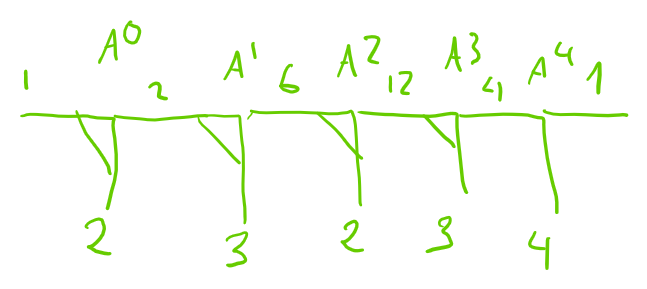

In [ ]:
[i.shape for i in mps]

In [ ]:
mps_final = compose_mps(mps)

In [ ]:
np.isclose(T, mps_final.reshape(T.shape)).all()

In [ ]:
size

In [ ]:
T.size

### Mas Pruebas

In [ ]:
tensor_dim = [2, 3, 2, 3, 4, 3] # local space dimensions
T = np.random.random(tuple(tensor_dim)) # rank-5 tensor
T = T / np.linalg.norm(T)

In [ ]:
mps, d_alphas, size = tn.mps_qr_lr_decompose(T)

In [ ]:
mps_final = compose_mps(mps)

In [ ]:
np.isclose(T, mps_final.reshape(T.shape)).all()

In [ ]:
# Elements of Tensor T
T.size

In [ ]:
size

In [ ]:
d_alphas

With QR decomposition the resultant MPS will have more elements than the original tensor. The resultant compose tensor should be exacte the same than the original one (until numerical computation precision)

In [ ]:
T.shape

The Left-to-Right QR decomposition give place to left isometries

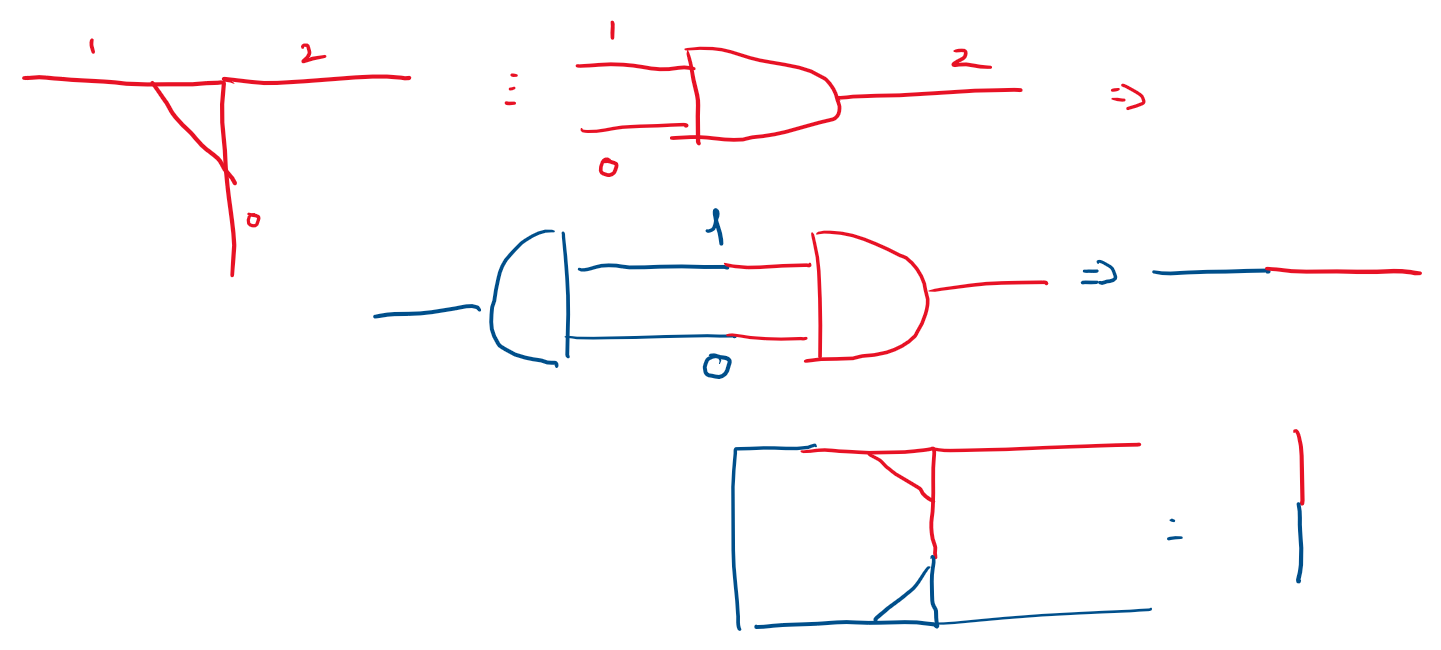

In [ ]:
#Testing Isometry U.T U = I
for tensor in mps:
    step_iso = tn.contract_indices(tensor, tensor, [0, 1], [0, 1])
    print(np.isclose(step_iso, np.identity(step_iso.shape[0])).all())

In [ ]:
#Testing Isometry_ U * U.T = P. P*P = P
for tensor in mps:
    a = tn.contract_indices(tensor, tensor, [2], [2])
    b = a.reshape(a.shape[0] * a.shape[1], a.shape[2] * a.shape[3])
    print(np.isclose(b @ b, b).all())